# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('structure of the data AZDIAS_subset', azdias.shape)
print('structure of the data AZDIAS_feature_summary', feat_info.shape)

structure of the data AZDIAS_subset (891221, 85)
structure of the data AZDIAS_feature_summary (85, 4)


In [4]:
# Roughly scanning the data AZDIAS_Subset
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# Identify missing or unknown data values and convert them to NaNs.

print('{} missing values are identified in the data.'.format(azdias.isnull().sum().sum()))

4896838 missing values are identified in the data.


In [9]:
for _, row in feat_info.iterrows():
    column = azdias[row['attribute']]

    missing_values = row['missing_or_unknown'][1:-1].split(',')
    if missing_values != ['']:
        for mv in missing_values:
            if mv != 'X' and mv != 'XX':
                column.replace(int(mv), np.nan, inplace = True)
            else:
                column.replace(mv, np.nan, inplace = True)

    azdias[row['attribute']] = column

In [10]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [12]:
count_missing_data = azdias.isnull().sum()
count_missing_data_percentage = azdias.isnull().sum()/ (azdias.shape[0]) * 100
only_missing = count_missing_data[count_missing_data > 0]
only_missing

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
                          ...  
OST_WEST

Text(0.5,1,'Missing values in the data')

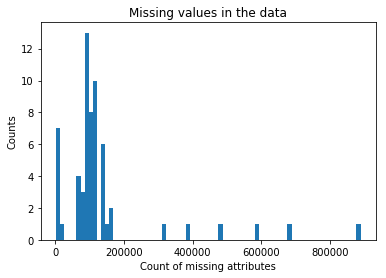

In [13]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(only_missing, bins='auto')
plt.xlabel('Count of missing attributes')
plt.ylabel('Counts')
plt.title('Missing values in the data')

Text(0.5,1,'Missing values in the data')

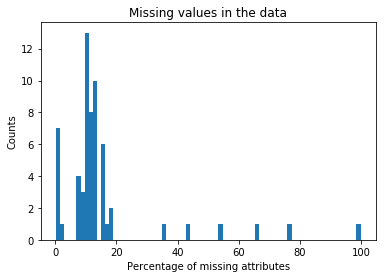

In [14]:
only_missing_percentage = (only_missing / (azdias.shape[0])) * 100
plt.hist(only_missing_percentage, bins='auto')
plt.xlabel('Percentage of missing attributes')
plt.ylabel('Counts')
plt.title('Missing values in the data')

In [15]:
only_missing_sorted = only_missing_percentage.sort_values(ascending=False)
only_missing_sorted

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

In [16]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_preprocessed = azdias.copy()
dropped_attributes = []
for idx in range(azdias.shape[1]):
    if (count_missing_data_percentage.index[idx] == azdias.columns[idx]) and count_missing_data_percentage[idx] > 20:
        #azdias_preprocessed.drop(azdias.columns[idx], axis=1, inplace=True)
        dropped_attributes.append(azdias.columns[idx])

print('Dropped attributes are ', dropped_attributes)
azdias_preprocessed.drop(dropped_attributes, axis=1, inplace=True)
azdias_preprocessed.head()

Dropped attributes are  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

Q: reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?

As shown in the above histogram, the distribution of the missing data illustrates that the amount of most missing data is less than 20 percent. However, there are few attributes showing a significant difference to the most of data. During the investigation, the attributes `['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']` are considered as outliers due to the significantly huge numbers of missing values, which probably have a negative influence on the later investigation. As result, they are dropped out from the original dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

Text(0.5,1,'Missing rows in the data')

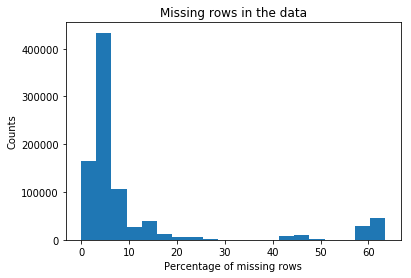

In [17]:
# How much data is missing in each row of the dataset?
n_missing_data_row = azdias.isnull().sum(axis=1)
percentage_missing_data_row = n_missing_data_row / azdias.shape[1] * 100

plt.hist(percentage_missing_data_row, bins=20)
plt.xlabel('Percentage of missing rows')
plt.ylabel('Counts')
plt.title('Missing rows in the data')

As illustrated in the histogram, the graphical center of distribution of missing rows is around 30 percent. The value is defined as threshold for dividing the data into two subsets.

In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
threshold = 30

missing_data_row_above_threshold = azdias[azdias.isnull().sum(axis=1) >= threshold]
missing_data_row_below_threshold = azdias[azdias.isnull().sum(axis=1) < threshold]

In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_distribution_plot(col_name):
    fig = plt.figure(figsize=(12,4))
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('Missing Rows above threshold')
    sns.countplot(azdias.loc[missing_data_row_above_threshold.index, col_name])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Missing Rows below threshold')
    sns.countplot(azdias.loc[missing_data_row_below_threshold.index, col_name])

In [20]:
# Pick the columns randomly
random_numbers = []
count = 1
while count < 6:
    count += 1
    r = np.random.randint(0, azdias.shape[1])
    if r not in random_numbers:
        random_numbers.append(r)
        
print('random indices: ',random_numbers)

random_column_names = []
[random_column_names.append(azdias.columns[idx]) for idx in random_numbers]
print('random names: ', random_column_names)

random indices:  [35, 83, 31, 48]
random names:  ['SEMIO_KAEM', 'ORTSGR_KLS9', 'SEMIO_KULT', 'W_KEIT_KIND_HH']


In [21]:
# freeze names when the workspace connection is lost
random_indices =  [4, 67, 42, 20, 53]
random_column_names = ['FINANZ_MINIMALIST', 'EWDICHTE', 'ZABEOTYP', 'LP_STATUS_GROB', 'KONSUMNAEHE']

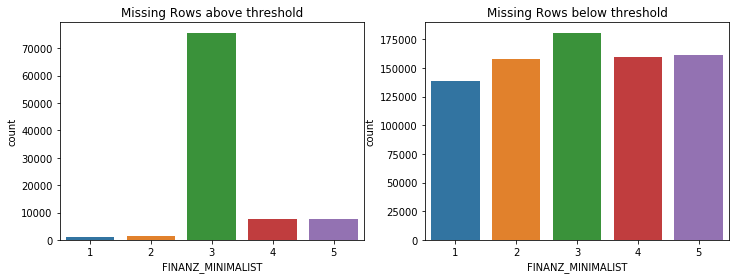

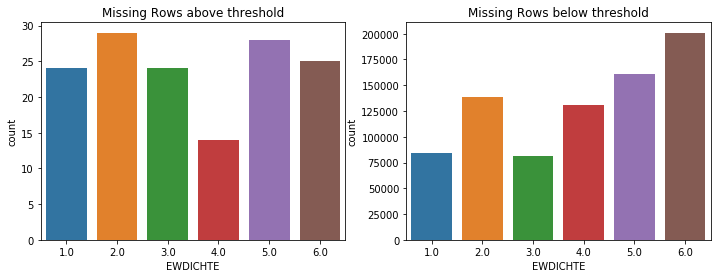

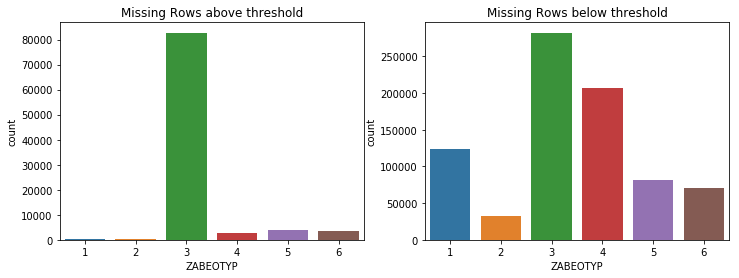

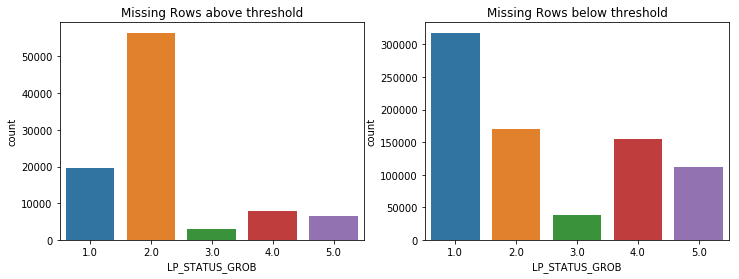

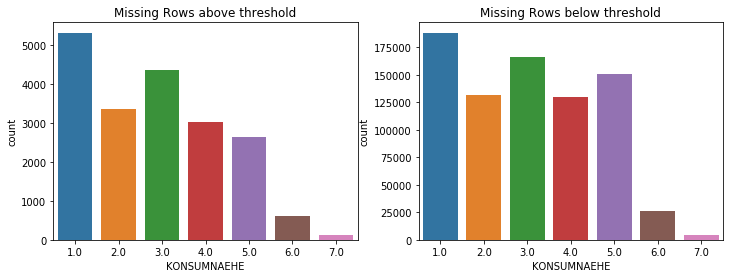

In [22]:
for col_name in random_column_names:
    compare_distribution_plot(col_name)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Q: reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?

The missing values in the row of the original dataset `azdias` is divided into two subsets by a threshold. The threshold is determined by a qualitative analysis. Subsequently, the distributions of missing rows of subsets are compared visually. Few features show partly similar distribution between two subsets, such as "FINANZ_MINIMALIST", however the most distributions of subsets are different. Since the randomly chosen features are not equal features, which are removed in the preprocessing, the preprocessing in the columns would have no impact in the investigation.

In [23]:
# Perform further preprocessing: only with missing data with below threshold
azdias_preprocessed = azdias_preprocessed[azdias_preprocessed.index.isin(missing_data_row_below_threshold.index)]
print('Dimension of preprocessed data = {}'.format(azdias_preprocessed.shape))

Dimension of preprocessed data = (797929, 79)


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [24]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [25]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

col_categorical = feat_info.loc[feat_info.type == 'categorical', 'attribute'].values
col_categorical

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [26]:
azdias_preprocessed.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [27]:
# Identifz categorical columns
column_categorical = []
for idx in range(min(len(col_categorical), len(azdias_preprocessed.columns))):
    if col_categorical[idx] in azdias_preprocessed.columns:
        column_categorical.append(col_categorical[idx])
column_categorical

['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [28]:
# Re-encode categorical variable(s) to be kept in the analysis.
# screen the values in the column
col_cat_binary = []
col_cat_multi_level = []
for column in column_categorical:
    if azdias_preprocessed[column].nunique() > 2:
        col_cat_multi_level.append(column)
    else:
        col_cat_binary.append(column)
        
for column in col_cat_binary:
    print(azdias_preprocessed[column].value_counts())

2    416094
1    381835
Name: ANREDE_KZ, dtype: int64
0    622715
1    175214
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791213
1.0      6716
Name: SOHO_KZ, dtype: int64
2.0    394224
1.0    367042
Name: VERS_TYP, dtype: int64
W    629410
O    168519
Name: OST_WEST_KZ, dtype: int64


In [29]:
# replace the value into 0 or 1
azdias_preprocessed['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
azdias_preprocessed['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias_preprocessed['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

In [30]:
# Check changes
for column in col_cat_binary:
    print(azdias_preprocessed[column].value_counts())

1    416094
0    381835
Name: ANREDE_KZ, dtype: int64
0    622715
1    175214
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791213
1.0      6716
Name: SOHO_KZ, dtype: int64
1.0    394224
0.0    367042
Name: VERS_TYP, dtype: int64
1    629410
0    168519
Name: OST_WEST_KZ, dtype: int64


In [31]:
azdias_preprocessed = pd.get_dummies(azdias_preprocessed, columns=col_cat_multi_level)

In [32]:
azdias_preprocessed.shape

(797929, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

Q: reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?

A brief scan into the binary categorical features shows that the values of binary are not equal. Therefore the values are standardized with a numeric value 0 or 1. For the multi-level categorical features, `pd.get_dummies` function is applied for encoding the features.

As dataset, the preprocessed dataset is used in order to avoid replacing NaN with numerical values.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for `decade`, and a binary variable for `movement`.
- "CAMEO_INTL_2015" combines information on two axes: `wealth` and `life stage`. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
azdias_preprocessed['PRAEGENDE_JUGENDJAHRE'].head()

1    14.0
2    15.0
3     8.0
4     8.0
5     3.0
Name: PRAEGENDE_JUGENDJAHRE, dtype: float64

In [34]:
# Engineering two columns with new variables
# according to the Data_Dictionary.md

# decade
decades = {0: [1, 2], # 40s
           1: [3, 4], # 50s
           2: [5, 6, 7], # 60s
           3: [8, 9], # 70s
           4: [10, 11, 12, 13], # 80s
           5:[14, 15]} # 90s

def map_decade(val):
    try:
        for key, values in decades.items():
            if val in values:
                return key
    # assign other cases to NaN
    except ValueError:
        return np.nan

# Movement
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_movement(val):
    try:
        if val in mainstream:
            return 1
        else:
            return 0
    except ValueError:
        return np.nan

In [35]:
# Create generation column
azdias_preprocessed['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_preprocessed['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)

# Create movement column
azdias_preprocessed['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_preprocessed['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

In [36]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_preprocessed['CAMEO_INTL_2015'].head()

1    51
2    24
3    12
4    43
5    54
Name: CAMEO_INTL_2015, dtype: object

In [37]:
# Define mapping functions
def map_wealth(val):
    if pd.isnull(val):
        return np.nan
    else:
        return int(str(val)[0])

def map_lifestage(val):
    if pd.isnull(val):
        return np.nan
    else:
        return int(str(val)[1])

In [38]:
# Create generation column
azdias_preprocessed['CAMEO_INTL_2015_wealth'] = azdias_preprocessed['CAMEO_INTL_2015'].apply(map_wealth)

# Create movement column
azdias_preprocessed['CAMEO_INTL_2015_lifestage'] = azdias_preprocessed['CAMEO_INTL_2015'].apply(map_lifestage)

In [39]:
# Drop features we do not need anymore
azdias_preprocessed = azdias_preprocessed.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis=1)

In [40]:
# Sanity check
if 'PRAEGENDE_JUGENDJAHRE' in azdias_preprocessed.columns:
    print('check again')
    
if 'CAMEO_INTL_2015' in azdias_preprocessed.columns:
    print('check again')

#### Discussion 1.2.2: Engineer Mixed-Type Features

Q: reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?

As described in the data dictionary, new values are mapped into the features "decade" and "movement" for the column PRAEGENDE_JUGENDJAHRE and subsequently new features are inserted into the dataset. For the column CAMEO_INTL_2015, the wealth and lifestage features are mapped with the equal method. The original features are removed from the dataset, respectively.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797929 entries, 1 to 891220
Columns: 196 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_lifestage
dtypes: float64(44), int64(24), uint8(128)
memory usage: 517.5 MB


In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_preprocessed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,1.0,1,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0,5.0,1,5.0,1.0
2,3.0,1,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,0,5.0,0,2.0,4.0
3,4.0,1,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0,3.0,1,1.0,2.0
4,3.0,0,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0,3.0,1,4.0,3.0
5,1.0,1,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0,1.0,1,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
def clean_data(df, feat_info, drop_col=dropped_attributes, threshold_row_missing_data=30, below=True):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
      
    INPUT:
        df: Demographics DataFrame
        feat_info: feature infomation
        drop_col: columns to be dropped
        threshold_row_missing_data: threshold in percentage for missing data in row
    
    OUTPUT:
        Trimmed and cleaned demographics DataFrame
    """
            
    def map_decade(val):
        try:
            for key, values in decades.items():
                if val in values:
                    return key

        # assign other cases to NaN
        except ValueError:
            return np.nan

    # Movement
    mainstream = [1, 3, 5, 8, 10, 12, 14]

    def map_movement(val):
        try:
            if val in mainstream:
                return 1
            else:
                return 0
        except ValueError:
            return np.nan
    
    # Define mapping functions
    def map_wealth(val):
        if pd.isnull(val):
            return np.nan
        else:
            return int(str(val)[0])

    def map_lifestage(val):
        if pd.isnull(val):
            return np.nan
        else:
            return int(str(val)[1])
    
    # Converting feature information into a structure for further data cleaning
    
    # convert missing value codes into NaNs, ...
    
    for _, row in feat_info.iterrows():
        column = df[row['attribute']]

        missing_values = row['missing_or_unknown'][1:-1].split(',')
        if missing_values != ['']:
            for mv in missing_values:
                if mv != 'X' and mv != 'XX':
                    column.replace(int(mv), np.nan, inplace = True)
                else:
                    column.replace(mv, np.nan, inplace = True)

        df[row['attribute']] = column
    # remove selected columns and rows, ...
    # same columns are dropped as in the dataset.
    
    df = df.drop(drop_col, axis=1)
        
    # rows
    missing_data_row_above_threshold = df[df.isnull().sum(axis=1) >= threshold_row_missing_data]
    missing_data_row_below_threshold = df[df.isnull().sum(axis=1) < threshold_row_missing_data]
    
    if below:
        df = df[df.index.isin(missing_data_row_below_threshold.index)]
        data_trimmed = missing_data_row_below_threshold
    else:
        df = df[df.index.isin(missing_data_row_above_threshold.index)]
        data_trimmed = missing_data_row_above_threshold
        
    
    print('dataset dimesion after trimming = ', df.shape)
    # select, re-encode, and engineer column values.
    col_categorical = feat_info.loc[feat_info.type == 'categorical', 'attribute'].values
    
    column_categorical = []
    for idx in range(min(len(col_categorical), len(df.columns))):
        if col_categorical[idx] in df.columns:
            column_categorical.append(col_categorical[idx])
    
    col_cat_binary = []
    col_cat_multi_level = []
    for column in column_categorical:
        if df[column].nunique() > 2:
            col_cat_multi_level.append(column)
        else:
            col_cat_binary.append(column)

    df['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)
    df['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    df['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    df = pd.get_dummies(df, columns=col_cat_multi_level)
    print('after_get_dummies = ', df.shape)
    
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_decade)
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE'].apply(map_movement)

    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015'].apply(map_wealth)
    df['CAMEO_INTL_2015_lifestage'] = df['CAMEO_INTL_2015'].apply(map_lifestage)

    df = df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1)
    
    # Return the cleaned dataframe.
    return df, data_trimmed    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [44]:
from sklearn.preprocessing import Imputer, StandardScaler

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


In [46]:
azdias_preprocessed.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
count,795129.000000,797929.000000,797929.000000,797929.000000,797929.000000,797929.000000,797929.000000,797929.000000,797929.000000,761266.000000,...,797929.000000,797929.000000,797929.000000,797929.000000,797929.000000,797929.000000,769248.000000,797929.000000,791826.000000,791826.000000
mean,2.795393,0.521467,3.058956,2.715943,3.432935,2.840827,2.658100,3.114291,0.219586,2.199043,...,0.022027,0.025744,0.034685,0.031315,0.035834,0.007994,3.331961,0.744470,3.262150,2.873016
std,1.018428,0.499539,1.377559,1.485072,1.376910,1.472736,1.399436,1.408072,0.413966,0.755166,...,0.146771,0.158371,0.182980,0.174167,0.185876,0.089054,1.457432,0.436159,1.464498,1.484778
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,0.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000
50%,3.000000,1.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,4.000000,3.000000
75%,4.000000,1.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,5.000000,4.000000
max,4.000000,1.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,5.000000,5.000000


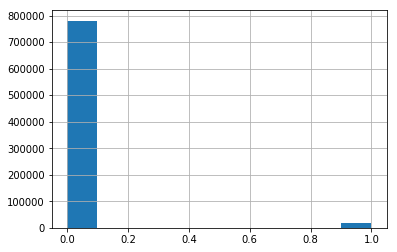

In [47]:
azdias_preprocessed['CAMEO_DEU_2015_8D'].hist()

In [48]:
feature = azdias_preprocessed.copy()
imputer = Imputer(strategy='median')
imputed_feature = imputer.fit_transform(feature)

In [49]:
azdias_preprocessed.shape

(797929, 196)

In [50]:
imputed_feature.shape

(797929, 196)

In [51]:
# Apply feature scaling to the general population demographics data.
scalar = StandardScaler()
standardized_feature = scalar.fit_transform(imputed_feature)

In [52]:
standardized_feature

array([[-1.76658916,  0.95794845, -1.49464187, ...,  0.58586511,
         1.18619805, -1.26695288],
       [ 0.20053785,  0.95794845, -1.49464187, ..., -1.70687754,
        -0.86817228,  0.76126693],
       [ 1.18410135,  0.95794845,  0.68312434, ...,  0.58586511,
        -1.55296238, -0.59087961],
       ..., 
       [-0.78302565,  0.95794845, -0.7687198 , ...,  0.58586511,
        -0.86817228,  0.76126693],
       [-1.76658916, -1.0438975 , -1.49464187, ...,  0.58586511,
         1.18619805, -1.26695288],
       [ 1.18410135, -1.0438975 ,  0.68312434, ...,  0.58586511,
         0.50140794,  0.08519366]])

### Discussion 2.1: Apply Feature Scaling

Q: reporting your decisions regarding feature scaling.

The imputation of the feature is performed with the median as "strategy". The decision is made by the analysis of the skewed distribution of features. The median is a powerful method in case of treating skewed distribution in the imputation. The imputed features are standardized subsequently.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [53]:
# Apply PCA to the data.

from sklearn.decomposition import PCA

pca = PCA()
pca_features = pca.fit_transform(standardized_feature)

In [54]:
# Investigate the variance accounted for by each principal component.

# from the helper_function in PCA chapter of Udacity
# modification such as figure sizes
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s" % ((str(vals[i]*100)[:3])), (ind[i], vals[i]), va="bottom", ha="center", fontsize=5)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

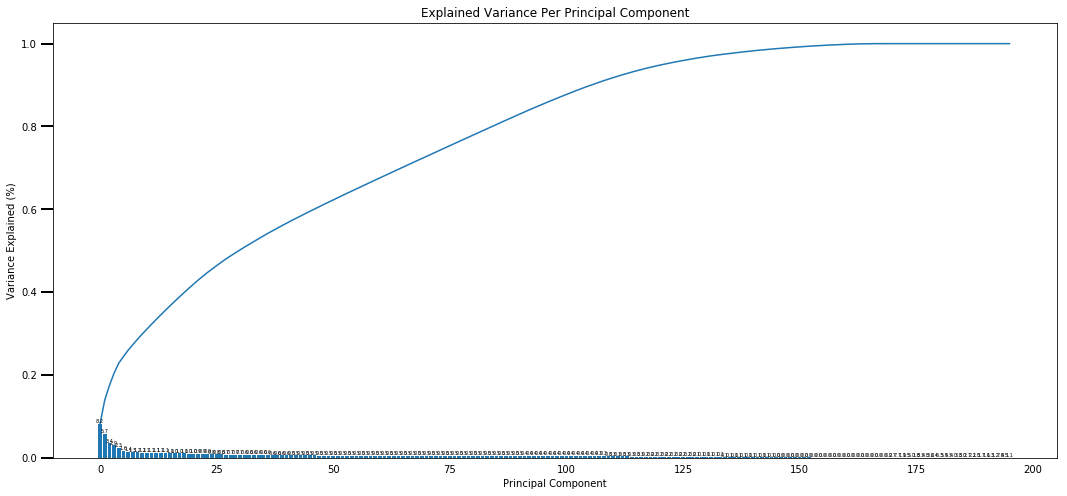

In [55]:
# first screen of PCA with default setting
scree_plot(pca)

In [56]:
# Re-apply PCA to the data while selecting for number of components to retain.
for i in np.arange(10, 30):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))
    print('{:.4f} slope of variance'.format(pca.explained_variance_ratio_[:i].sum() - pca.explained_variance_ratio_[:i-5].sum()))


10 components explain 0.2983818821638602 of variance.
0.0700 slope of variance
11 components explain 0.3103266786268973 of variance.
0.0658 slope of variance
12 components explain 0.3221201377716139 of variance.
0.0626 slope of variance
13 components explain 0.3336106481570968 of variance.
0.0607 slope of variance
14 components explain 0.3449780109250939 of variance.
0.0591 slope of variance
15 components explain 0.3561374728474488 of variance.
0.0578 slope of variance
16 components explain 0.36706694416325486 of variance.
0.0567 slope of variance
17 components explain 0.37778468403330867 of variance.
0.0557 slope of variance
18 components explain 0.38838751571692703 of variance.
0.0548 slope of variance
19 components explain 0.3987844097496105 of variance.
0.0538 slope of variance
20 components explain 0.40904783903378855 of variance.
0.0529 slope of variance
21 components explain 0.4190919236145322 of variance.
0.0520 slope of variance
22 components explain 0.4288045712558583 of vari

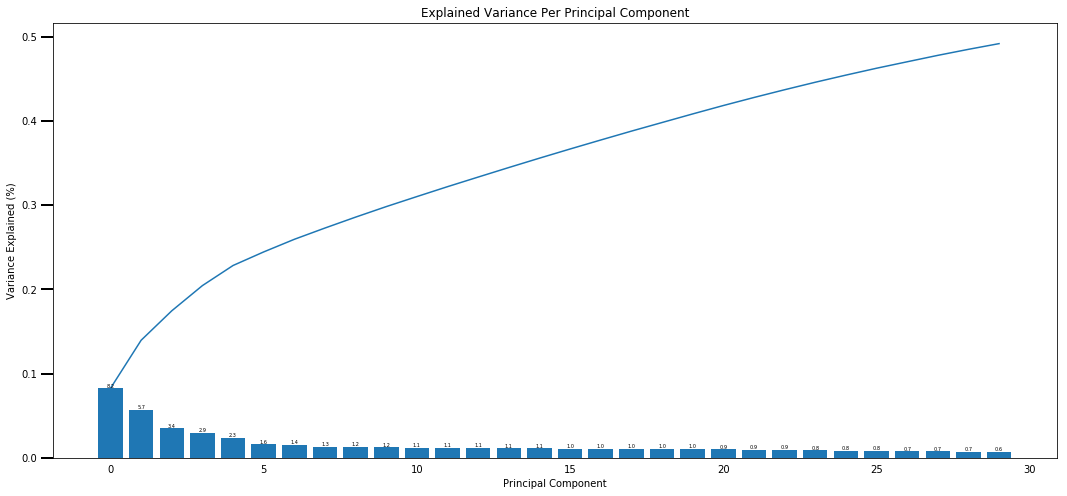

In [57]:
pca = PCA(30)
pca_features = pca.fit_transform(standardized_feature)
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

Q: reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?

At the beginning of investigation, the default setting of sklearn PCA is applied in order to obtain the entire overview of number of principal components. For the next step of analysis, I would like to retain 30 principal components of features. According to the analysis of explained variance ratio and the slope of varaince explained, about 50 % of data variability (cumulative variance explained) is exceeded and the number of features is more than a half of originial number of features.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [58]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def plot_pca_result(data, pca, n_components):
    components = pd.DataFrame(np.round(pca.components_, 4), columns = data.keys()).iloc[n_components - 1]
    components.sort_values(ascending=False, inplace=True)
    components = pd.concat([components.head(5), components.tail(5)])
    
    components.plot(kind = 'bar', title= '10 weighted features of {} PCA components'.format(n_components))
    return components

LP_STATUS_GROB_1.0        0.1890
HH_EINKOMMEN_SCORE        0.1799
CAMEO_INTL_2015_wealth    0.1796
PLZ8_ANTG3                0.1789
PLZ8_ANTG4                0.1737
KBA05_GBZ                -0.1762
FINANZ_MINIMALIST        -0.1796
PLZ8_ANTG1               -0.1799
KBA05_ANTG1              -0.1834
MOBI_REGIO               -0.1998
Name: 0, dtype: float64

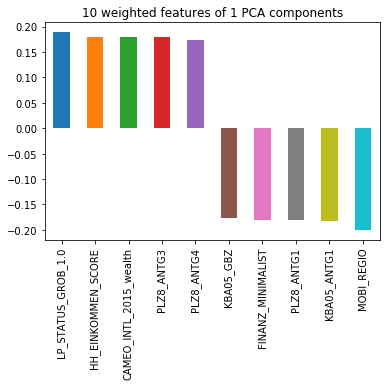

In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

plot_pca_result(azdias_preprocessed, pca, 1)

ALTERSKATEGORIE_GROB            0.2375
FINANZ_VORSORGER                0.2234
ZABEOTYP_3                      0.1994
SEMIO_ERL                       0.1812
SEMIO_LUST                      0.1664
SEMIO_TRADV                    -0.2107
FINANZ_UNAUFFAELLIGER          -0.2167
SEMIO_REL                      -0.2174
FINANZ_SPARER                  -0.2338
PRAEGENDE_JUGENDJAHRE_decade   -0.2419
Name: 1, dtype: float64

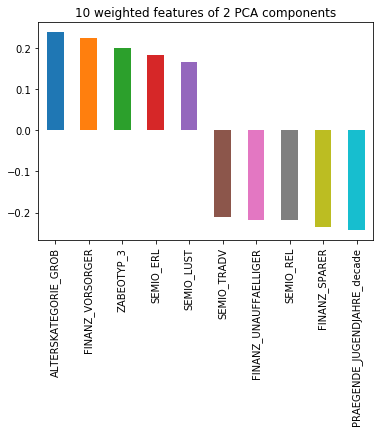

In [60]:
plot_pca_result(azdias_preprocessed, pca, 2)

SEMIO_VERT     0.3167
SEMIO_FAM      0.2575
SEMIO_SOZ      0.2550
SEMIO_KULT     0.2489
FINANZTYP_5    0.1362
SEMIO_ERL     -0.2063
SEMIO_KRIT    -0.2666
SEMIO_DOM     -0.2785
SEMIO_KAEM    -0.3107
ANREDE_KZ     -0.3416
Name: 2, dtype: float64

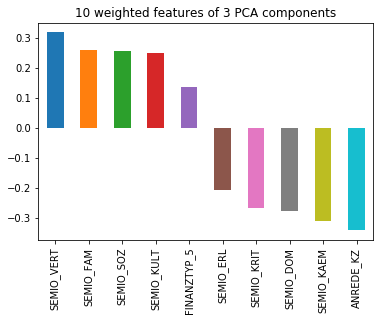

In [61]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
plot_pca_result(azdias_preprocessed, pca, 3)

### Discussion 2.3: Interpret Principal Components

Q: reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?

To obtain better insights of displayed features, the description of 3 top / bottom features has to be considered.

The first principal component has a positive association with:
- LP_STATUS_GROB_1: Social status, low-income earners
- HH_EINKOMMEN_SCORE: Estimated household net income
- CAMEO_INTL_2015_wealth: Household wealth

a negative association with:
- MOBI_REGIO: Movement patterns
- KBA05_ANTG1: Number of 1-2 family houses in the microcell
- PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region

==> As listed, the first components indicate the relation to the financial status, local information (such as movement, PLZ8 region)

The second principal component has a positive association with:
- ALTERSKATEGORIE_GROB: Estimated age based on given name analysis
- FINANZ_VORSORGER: Financial typology
- ZABEOTYP_3: Energy consumption typology, fair supplied

a negative association with:
- PRAEGENDE_JUGENDJAHRE_decade: Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- FINANZ_SPARER: Financial typology
- SEMIO_REL: Personality typology, religious

==> it appears that the second principal component is influenced by the factor: age, finanical treatment

The third principal component has a positive association with:
- SEMIO_VERT: Personality typology, dreamful 
- SEMI_FAM: Personality typology, family-minded
- SEMIO_SOZ: Personality typology, socially-minded

a negative association with:
- ANREDE_KZ: Gender
- SEMIO_KAEM: Personality typology, combative attitude
- SEMIO_DOM: Personality typology, dominant-minded

==> The third principal component is strongly linked with the traits of individuals such as personlaity, gender.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [62]:
from sklearn.cluster import KMeans

In [63]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score

In [64]:
pca_features.shape

(797929, 30)

In [65]:
# Due to high computational cost only 30 % of rows of features are used.
pca_features_random_sample = pca_features[np.random.choice(pca_features.shape[0], int(pca_features.shape[0]*0.2), replace=False)]

In [66]:
pca_features_random_sample.shape

(159585, 30)

In [67]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.


scores = []
centers = list(range(1,30))

for center in centers:
    score = get_kmeans_score(pca_features_random_sample, center)
    scores.append(score)
    print('clustering for {} k, with score {}'.format(center, score))

clustering for 1 k, with score 15379172.197127074
clustering for 2 k, with score 13408871.884391746
clustering for 3 k, with score 12524718.610623002
clustering for 4 k, with score 11942915.95278784
clustering for 5 k, with score 11463777.217227902
clustering for 6 k, with score 11172102.751856226
clustering for 7 k, with score 10912351.731000034
clustering for 8 k, with score 10696550.535288442
clustering for 9 k, with score 10468169.091704397
clustering for 10 k, with score 10292828.135735683
clustering for 11 k, with score 10097392.175470773
clustering for 12 k, with score 9971964.88994019
clustering for 13 k, with score 9754133.687284794
clustering for 14 k, with score 9640647.044791777
clustering for 15 k, with score 9544559.324580858
clustering for 16 k, with score 9439347.813833097
clustering for 17 k, with score 9329992.169239998
clustering for 18 k, with score 9244607.008555043
clustering for 19 k, with score 9127064.902812768
clustering for 20 k, with score 8989937.46545121
c

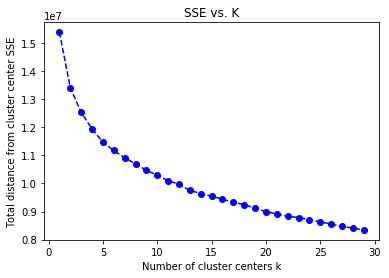

In [68]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('Number of cluster centers k');
plt.ylabel('Total distance from cluster center SSE');
plt.title('SSE vs. K');

In [69]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=25)
cluster_general = kmeans.fit(pca_features)
kmeans_general = kmeans.predict(pca_features)

### Discussion 3.1: Apply Clustering to General Population

Q: reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?

The plot shows a stagnant progress about 25 number of clusters. As dicted in the figure, further decrease of curve can be expected. Due to the high computational cost, I've decided to re-fit the k-means model with 25 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [70]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [71]:
customers.shape

(191652, 85)

In [72]:
dropped_attributes

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [73]:
# compare two dataset in column
print('azdias vs. customers - total number of difference: {}'.format(len(list(set(azdias.columns) - set(customers.columns)))))
#list(set(azdias.columns) - set(customers.columns))

azdias vs. customers - total number of difference: 0


In [74]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_preprocessed, feature_customers_trimmed = clean_data(customers, feat_info)

dataset dimesion after trimming =  (141725, 79)
after_get_dummies =  (141725, 193)


In [75]:
# Compare dataset
print('azdias_preprocessed vs. customers_preprocessed - total number of difference: {}'.format(len(list(set(azdias_preprocessed.columns) - set(customers_preprocessed.columns)))))
#list(set(azdias_preprocessed.columns) - set(customers.columns))

azdias_preprocessed vs. customers_preprocessed - total number of difference: 1


In [76]:
customers_preprocessed.shape

(141725, 195)

In [77]:
azdias_preprocessed.shape

(797929, 196)

In [78]:
list(set(azdias_preprocessed.columns) - set(customers_preprocessed.columns))

['GEBAEUDETYP_5.0']

In [79]:
azdias['GEBAEUDETYP'].nunique()

7

In [80]:
customers['GEBAEUDETYP'].nunique()

6

The customer dataset contains more number of unique values in the feature 'GEBAEUDETYP'. The mismatch of dimension of dataset leads to that the previous preprocessing objects are not able to be applied. Therefore, as remedy, I will insert a single number of unique '5' into the customer dataset (in the last row) and after the feature scaling I remove the row subsequently.

In [81]:
# remedy of above problem
customers_add_nunique = customers.copy()
last_row = customers.iloc[-1:]

In [82]:
customers_add_nunique.iloc[-1:]

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
191651,3.0,2.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0


In [83]:
# replicate last row
customers_add_nunique = customers_add_nunique.append(last_row, ignore_index=True, sort=False)
customers_add_nunique.tail()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
191648,NaN,4.0,2,2.0,5,1,5,2,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0
191649,2.0,4.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
191650,3.0,3.0,2,4.0,2,1,5,1,2,5,...,3.0,2.0,1.0,1.0,1.0,2.0,3.0,3.0,4.0,4.0
191651,3.0,2.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0
191652,3.0,2.0,1,2.0,5,1,5,1,1,2,...,3.0,2.0,0.0,0.0,1.0,4.0,5.0,1.0,3.0,1.0


In [84]:
# add the unique 5.0 in 'GEBAEUDETYP'
customers_add_nunique.loc[191652, 'GEBAEUDETYP'] = 5.0
customers_add_nunique.loc[191650:191652, 'GEBAEUDETYP']

191650    3.0
191651    1.0
191652    5.0
Name: GEBAEUDETYP, dtype: float64

In [85]:
# preprocessing
customers_preprocessed_features, customers_trimmed = clean_data(customers_add_nunique, feat_info)
list(set(azdias_preprocessed.columns) - set(customers_preprocessed_features.columns))

dataset dimesion after trimming =  (141726, 79)
after_get_dummies =  (141726, 194)


[]

In [86]:
customers_preprocessed_features.loc[191650:191652, 'GEBAEUDETYP_5.0']

191650    0
191651    0
191652    1
Name: GEBAEUDETYP_5.0, dtype: uint8

In [87]:
# drop the last row for perfoming the inputation and scaling
customers_preprocessed_features = customers_preprocessed_features.drop([191652])
print(customers_preprocessed_features.loc[191650:191651, 'GEBAEUDETYP_5.0'])
customers_preprocessed_features.tail()

191650    0
191651    0
Name: GEBAEUDETYP_5.0, dtype: uint8


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
191647,3.0,0,5,1,5,1,1,2,1,3.0,...,0,0,0,0,0,0,1.0,0,1.0,4.0
191648,4.0,1,5,1,5,2,2,3,0,2.0,...,0,0,0,0,0,0,2.0,1,3.0,2.0
191649,4.0,0,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,0,1.0,0,2.0,4.0
191650,3.0,1,2,1,5,1,2,5,0,2.0,...,0,0,0,0,0,0,3.0,1,2.0,4.0
191651,2.0,0,5,1,5,1,1,2,0,2.0,...,0,0,0,0,0,0,1.0,1,3.0,3.0


In [88]:
# imputation and scaling
imputed_customers = imputer.transform(customers_preprocessed_features)
scaled_customers = scalar.transform(imputed_customers)
pca_customers = pca.transform(scaled_customers)

In [89]:
kmeans_customers = kmeans.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [90]:
print('scan kmeans general', kmeans_general)
print('scan kmeans customers', kmeans_customers)

scan kmeans general [18  2 19 ...,  2 13  6]
scan kmeans customers [ 7 20 19 ..., 10  1  4]


In [94]:
from collections import Counter

cust_data = Counter(kmeans_customers)
germany_data = Counter(kmeans_general)
cnter = 1
print("For the company, we have the following characteristics:")
prop_cust=[]
for val in cust_data:
    prop = cust_data[val]/customers.shape[0]
    prop_cust.append(prop)
    print('Cluster ' + str(cnter) + ' has proportion ' + str(prop))
    cnter+=1

print('\n')
print("For the population of Germany, we have the following characteristics:")   
cnter = 1
prop_general=[]
for val in germany_data:
    prop = germany_data[val]/azdias.shape[0]
    prop_general.append(prop)
    print('Cluster ' + str(cnter) + ' has proportion ' + str(prop))
    cnter+=1

For the company, we have the following characteristics:
Cluster 1 has proportion 0.06837914553461483
Cluster 2 has proportion 0.03225638135787782
Cluster 3 has proportion 0.05706175776929017
Cluster 4 has proportion 0.025640222904013524
Cluster 5 has proportion 0.04701229311460355
Cluster 6 has proportion 0.074911819339219
Cluster 7 has proportion 0.033868678646713835
Cluster 8 has proportion 0.027497756350051136
Cluster 9 has proportion 0.10528979608874418
Cluster 10 has proportion 0.0030002295827854654
Cluster 11 has proportion 0.02609417068436541
Cluster 12 has proportion 0.008588483292634567
Cluster 13 has proportion 0.06677206603635756
Cluster 14 has proportion 0.029245716193934842
Cluster 15 has proportion 0.038131613549558574
Cluster 16 has proportion 0.007195333208106359
Cluster 17 has proportion 0.002838478074843988
Cluster 18 has proportion 0.024779287458518564
Cluster 19 has proportion 0.005290839646859934
Cluster 20 has proportion 0.01952497234570993
Cluster 21 has proporti

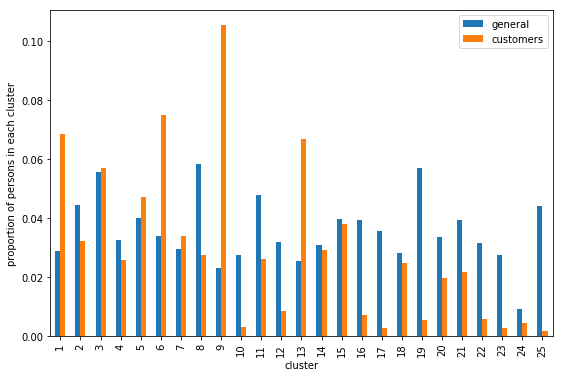

In [95]:
df_prop = pd.DataFrame({'cluster' : x_values, 'general' : prop_general, 'customers':prop_cust})
df_prop.plot(x='cluster', y = ['general', 'customers'], kind='bar', figsize=(9,6))
plt.ylabel('proportion of persons in each cluster')
plt.show()

In [133]:
overrepresent = np.argmax(np.subtract(prop_cust, prop_general))+1
print('number of overrepresented cluster = ', overrepresent)
underrepresent = np.argmax(np.subtract(prop_general, prop_cust))+1
print('number of underrepresent cluster = ', underrepresent)

number of overrepresented cluster =  9
number of underrepresent cluster =  19


CAMEO_INTL_2015_lifestage    0.2452
ARBEIT                       0.1705
CAMEO_DEU_2015_3D            0.1394
FINANZTYP_6                  0.1391
CAMEO_DEUG_2015_3            0.1166
CAMEO_DEUG_2015_7           -0.1827
PLZ8_GBZ                    -0.2815
PLZ8_HHZ                    -0.3296
OST_WEST_KZ                 -0.3334
KBA13_ANZAHL_PKW            -0.3388
Name: 8, dtype: float64

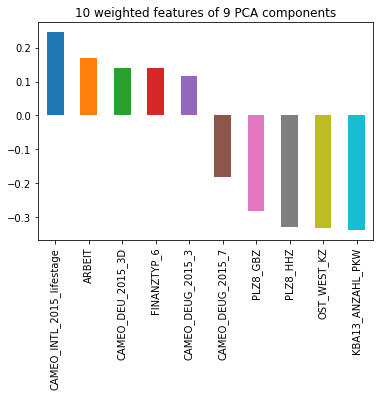

In [134]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

plot_pca_result(customers_preprocessed_features, pca, overrepresent)

In [142]:
cluster_overrepresent = scalar.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[overrepresent-1]))
cluster_overrepresent = pd.Series(cluster_overrepresent).round()
cluster_overrepresent.index = customers_preprocessed_features.columns
print('============= positive association =============')
print('CAMEO_INTL_2015_lifestage =', cluster_overrepresent['CAMEO_INTL_2015_lifestage'])
print('ARBEIT =', cluster_overrepresent['ARBEIT'])
print('CAMEO_DEU_2015_3D =', cluster_overrepresent['CAMEO_DEU_2015_3D'])
print('FINANZTYP_6 =', cluster_overrepresent['FINANZTYP_6'])
print('CAMEO_DEUG_2015_3 =', cluster_overrepresent['CAMEO_DEUG_2015_3'])
print('============= negative association =============')
print('KBA13_ANZAHL_PKW =', cluster_overrepresent['KBA13_ANZAHL_PKW'])
print('OST_WEST_KZ =', cluster_overrepresent['OST_WEST_KZ'])
print('PLZ8_HHZ =', cluster_overrepresent['PLZ8_HHZ'])
print('PLZ8_GBZ =', cluster_overrepresent['PLZ8_GBZ'])
print('CAMEO_DEUG_2015_7 =', cluster_overrepresent['CAMEO_DEUG_2015_7'])

============= positive association =============
CAMEO_INTL_2015_lifestage = 2.0
ARBEIT = 4.0
CAMEO_DEU_2015_3D = 0.0
FINANZTYP_6 = 0.0
CAMEO_DEUG_2015_3 = 0.0
============= negative association =============
KBA13_ANZAHL_PKW = 539.0
OST_WEST_KZ = 1.0
PLZ8_HHZ = 4.0
PLZ8_GBZ = 3.0
CAMEO_DEUG_2015_7 = 0.0


According to the result of inverse transformation, the traits are assigned.

The 9th principal component has a positive association with:

- CAMEO_INTL_2015_lifestage (German CAMEO: Wealth / Life Stage Typology, mapped to international code): Wealthy Households - Families With School Age Children
- ARBEIT (Share of unemployment in community): high
- CAMEO_DEU_2015_3D (German CAMEO: Wealth / Life Stage Typology, detailed scale): Secure Retirement
- FINANZTYP_6 (Most descriptive financial type for individual): inconspicuous (UNAUFFAELLIGER)
- CAMEO_DEUG_2015_3 (German CAMEO: Wealth / Life Stage Typology, rough scale): established middleclass

a negative association with:
- KBA13_ANZAHL_PKW (Number of cars in the PLZ8 region):   
- OST_WEST_KZ  (Building location via former East / West Germany (GDR / FRG)): West (FRG)
- PLZ8_HHZ (Number of households within the PLZ8 region): 600-849 households
- PLZ8_GBZ (Number of buildings within the PLZ8 region): 300-449 buildings
- CAMEO_DEUG_2015_7 (German CAMEO: Wealth / Life Stage Typology, rough scale): lower middleclass

==> Accroding to the visualization of proportion of persons in each clusters, the cluster 9 is the most overrepresented cluster in the customer. The observation of visual and inverse transformation results shows that many traits indicate wealthy familiy with school age children and secure retirement. The statues of requirement might imply the familiy group with old age.

LP_FAMILIE_GROB_3.0    0.2207
CAMEO_DEUG_2015_2      0.2098
CAMEO_DEU_2015_2D      0.1660
LP_FAMILIE_FEIN_5.0    0.1479
CAMEO_DEUG_2015_3      0.1455
BALLRAUM              -0.1401
CAMEO_DEU_2015_1A     -0.1468
CAMEO_DEU_2015_1D     -0.1796
CAMEO_DEUG_2015_5     -0.2493
CAMEO_DEUG_2015_1     -0.2762
Name: 18, dtype: float64

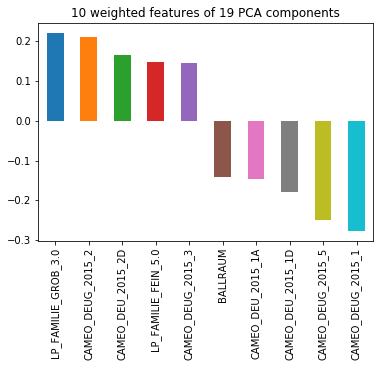

In [138]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

plot_pca_result(customers_preprocessed_features, pca, underrepresent)

In [143]:
cluster_underrepresent = scalar.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[underrepresent-1]))
cluster_underrepresent = pd.Series(cluster_underrepresent).round()
cluster_underrepresent.index = customers_preprocessed_features.columns
print('============= positive association =============')
print('LP_FAMILIE_GROB_3.0 =', cluster_underrepresent['LP_FAMILIE_GROB_3.0'])
print('CAMEO_DEUG_2015_2 =', cluster_underrepresent['CAMEO_DEUG_2015_2'])
print('CAMEO_DEU_2015_2D =', cluster_underrepresent['CAMEO_DEU_2015_2D'])
print('LP_FAMILIE_FEIN_5.0 =', cluster_underrepresent['LP_FAMILIE_FEIN_5.0'])
print('CAMEO_DEUG_2015_3 =', cluster_underrepresent['CAMEO_DEUG_2015_3'])
print('============= negative association =============')
print('CAMEO_DEUG_2015_1 =', cluster_underrepresent['CAMEO_DEUG_2015_1'])
print('CAMEO_DEUG_2015_5 =', cluster_underrepresent['CAMEO_DEUG_2015_5'])
print('CAMEO_DEU_2015_1D =', cluster_underrepresent['CAMEO_DEU_2015_1D'])
print('CAMEO_DEU_2015_1A =', cluster_underrepresent['CAMEO_DEU_2015_1A'])
print('BALLRAUM =', cluster_underrepresent['BALLRAUM'])

============= positive association =============
LP_FAMILIE_GROB_3.0 = 1.0
CAMEO_DEUG_2015_2 = 0.0
CAMEO_DEU_2015_2D = 0.0
LP_FAMILIE_FEIN_5.0 = 0.0
CAMEO_DEUG_2015_3 = 0.0
============= negative association =============
CAMEO_DEUG_2015_1 = 0.0
CAMEO_DEUG_2015_5 = 0.0
CAMEO_DEU_2015_1D = 0.0
CAMEO_DEU_2015_1A = 0.0
BALLRAUM = 4.0


According to the result of inverse transformation, the traits are assigned.

The 19th principal component has a positive association with:

- LP_FAMILIE_GROB_3.0  (Family type, rough scale)): single parent (maps to 3-5 in fine scale)
- CAMEO_DEUG_2015_2  (erman CAMEO: Wealth / Life Stage Typology, rough scale): upper middleclass       
- CAMEO_DEU_2015_2D  (German CAMEO: Wealth / Life Stage Typology, detailed scale): Fine Management
- LP_FAMILIE_FEIN_5.0 (Family type, fine scale): single parent with child of full age
- CAMEO_DEUG_2015_3  (erman CAMEO: Wealth / Life Stage Typology, rough scale): established middleclass

a negative association with:
- CAMEO_DEUG_2015_1 (German CAMEO: Wealth / Life Stage Typology, rough scale): upper class      
- CAMEO_DEUG_2015_5 (German CAMEO: Wealth / Life Stage Typology, rough scale): active middleclass
- CAMEO_DEU_2015_1D (German CAMEO: Wealth / Life Stage Typology, detailed scale): Old Nobility
- CAMEO_DEU_2015_1A (German CAMEO: Wealth / Life Stage Typology, detailed scale): Work-Life-Balance
- BALLRAUM (Distance to nearest urban center): 40 -  50 km

==> Accroding to the visualization of proportion of persons in each clusters, the cluster 19 is underrepresented in the customer and shows the high proportion of population. The observation of visual and inverse transformation results indicates single parents, those who belong to middleclass.

### Discussion 3.3: Compare Customer Data to Demographics Data

Q: reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?

As depicted in the comparison of proportion of persons, the targeting of company is not efficient. It is clearly to see that some clusters of customers are overweighted. The most overrepresented cluster 9 indicates customers with financially secured group. Interestingly, the underrepresented group heavily shows people with the state of wealth, as well. On the contrary, the people with the middleclass are dominant in the cluster 19.

It is hard to estimate the popularity of the mail-order company only based on the single characteristics, namely state of wealth. However, the detail information such as the family status provides us more insights of the group. The overrepresented cluster shows the family with school age children and the family with secure retirement. The mail-order company might relatively be popular to this type of family. On the other hand, the company might not be popular to the group with secure retirement regarding their age, who probably prefers offline shopping.

However, the company might be popular to the underrepresented group, because the middleclass sigle parents with children can have less time to go out for shopping. Thus, as mail-order company, this group might be interesting.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.